In [73]:
# General
import pandas as pd
from datetime import date as dt
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Machine Learning
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb

# for assessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_roc_curve

In [74]:
teams_internal = {'LAL':'LAL','GSW':'GSW','BOS':'BOC','MIA':'MIH', 'CHI':'CHB'}

In [75]:
df_tweet = pd.DataFrame()

for team in teams_internal:
    new = pd.read_csv('C:/Users/Marc/Dropbox/06_ESCP/01_Uni/06_MA Thesis/04_Code/02_Output/02_Tweets/' + teams_internal[team] + '/02_Tweets/01_Final/' + teams_internal[team] + 'per_Game_sentiment_24H.csv')
    new = new.rename(columns = {'Unnamed: 0': 'game_date' })
    new = new.fillna(new.mean())
    new['team'] = str(teams_internal[team])
    df_tweet = df_tweet.append(new)

df_tweet = df_tweet.drop(columns = ['cleaned', 'before',
       'token_lemma', 'created_at', 'Va_sentiment', '_before_Va_sentiment'])

In [76]:
df_stats = pd.read_excel('C:/Users/Marc/Dropbox/06_ESCP/01_Uni/06_MA Thesis/04_Code/02_Output/01_NBA Scheudle & Stats/LAL/03_stats_merged with opponent/LAL_hist_data_overview.xlsx')

for teams in teams_internal:
    df_stats_add = pd.read_excel('C:/Users/Marc/Dropbox/06_ESCP/01_Uni/06_MA Thesis/04_Code/02_Output/01_NBA Scheudle & Stats/'+ teams_internal[teams] + '/03_stats_merged with opponent/'+ teams_internal[teams] + '_hist_data_overview.xlsx')
    df_stats = df_stats.append(df_stats_add)

In [77]:
# Change Datetime format so left join works after
df_stats['Date'] = pd.to_datetime(df_stats['Date']).dt.date
df_tweet['game_date'] = pd.to_datetime(df_tweet['game_date']).dt.date


In [78]:
# Left Join to receive game outcomes for games with tweets scraped
df_full = pd.merge(df_tweet, df_stats, how = 'left', left_on = ['game_date', 'team'], right_on = ['Date', 'Home Team'])


df_full.columns

Index(['game_date', 'TB_polarity', 'TB_subjectivity', 'Va_neg', 'Va_neu',
       'Va_pos', 'Va_compound', '_before_TB_polarity',
       '_before_TB_subjectivity', '_before_Va_neg', '_before_Va_neu',
       '_before_Va_pos', '_before_Va_compound', 'team', 'G', 'Home Team',
       'Date', 'Home / Away', 'Opp', 'W/L', 'Losses_streak', 'Wins_streak',
       'Opp_Losses_streak', 'Opp_Wins_streak', 'Diff_P_Team',
       'Diff_P_Received', 'Diff_FG', 'Diff_FGA', 'Diff_3P', 'Diff_3PA',
       'Diff_FT', 'Diff_FTA', 'Diff_ORB', 'Diff_TRB', 'Diff_AST', 'Diff_STL',
       'Diff_BLK', 'Diff_TOV', 'Diff_PF', 'Diff_FG%', 'Diff_3P%', 'Diff_FT%',
       'Diff_P_Team_5GA', 'Diff_P_Rec_5GA', 'Diff_FG_5GA', 'Diff_FGA_5GA',
       'Diff_3P_5GA', 'Diff_3PA_5GA', 'Diff_FT_5GA', 'Diff_FTA_5GA',
       'Diff_ORB_5GA', 'Diff_TRB_5GA', 'Diff_AST_5GA', 'Diff_STL_5GA',
       'Diff_BLK_5GA', 'Diff_TOV_5GA', 'Diff_PF_5GA', 'Diff_FG%_5GA',
       'Diff_3P%_5GA', 'Diff_FT%_5GA', 'Diff_win_per', 'Diff_win_per_5G',
  

# Prediction only based on sentiments

In [79]:
df_sent = df_full[['TB_polarity', 'TB_subjectivity', 'Va_neg', 'Va_neu',
       'Va_pos', 'Va_compound', '_before_TB_polarity',
       '_before_TB_subjectivity', '_before_Va_neg', '_before_Va_neu',
       '_before_Va_pos', '_before_Va_compound','W/L']]

In [80]:
# y (dependent) in binary
Y = df_sent['W/L'].map(dict(W = 1, L = 0))
#df_sent['y'] = y
df_sent = df_sent.drop(columns = ['W/L'])


# Correlation inspection

<AxesSubplot:>

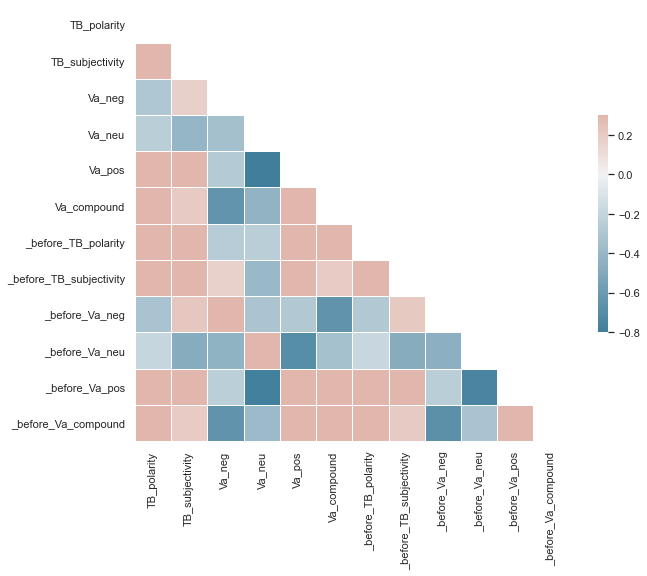

In [81]:
# Correlation Heatmap
# Used instead of Variance Inflation Factor, as the dataset contains averages over past 5 games or just of the current seasonon until the game
sns.set_theme(style="white")

# Compute the correlation matrix
corr = df_sent.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [82]:
# According to Chen and Rothschild, 2010, --> 0.9 = multicolinearity is certain
# Filtering out the columns that have a correlation of more than 0.9
abs_corr = corr.abs()
abs_corr_filtered = abs_corr[abs_corr >= 0.825]
abs_corr_filtered.loc[:, (abs_corr_filtered.sum() >= 2.65)].columns


# First all correlations made absolute, then filtered for above or equal to 0.9, and then names extraced that are more than 2.8 (self correlated, lower and upper triangle)

### None of the features have a correlation of higer than 0.9, hence no multicolinearity to be taken care of

Index(['Va_pos', 'Va_compound', '_before_Va_pos', '_before_Va_compound'], dtype='object')

# Scaling

[Text(0, 0, 'TB_polarity'),
 Text(1, 0, 'TB_subjectivity'),
 Text(2, 0, 'Va_neg'),
 Text(3, 0, 'Va_neu'),
 Text(4, 0, 'Va_pos'),
 Text(5, 0, 'Va_compound'),
 Text(6, 0, '_before_TB_polarity'),
 Text(7, 0, '_before_TB_subjectivity'),
 Text(8, 0, '_before_Va_neg'),
 Text(9, 0, '_before_Va_neu'),
 Text(10, 0, '_before_Va_pos'),
 Text(11, 0, '_before_Va_compound')]

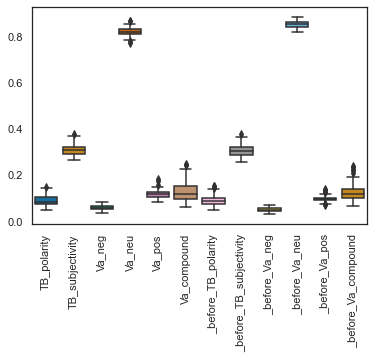

In [83]:
# boxpltos
boxp = sns.boxplot(data=df_sent ,palette="colorblind")
boxp.set_xticklabels(boxp.get_xticklabels(),rotation=90)

In [84]:
df_sent.describe()

# Difference in Min Max Values

,TB_polarity,TB_subjectivity,Va_neg,Va_neu,Va_pos,Va_compound,_before_TB_polarity,_before_TB_subjectivity,_before_Va_neg,_before_Va_neu,_before_Va_pos,_before_Va_compound
count,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000
mean,0.088073,0.310125,0.059632,0.822136,0.117427,0.129842,0.090602,0.306960,0.050531,0.852279,0.097191,0.125536
std,0.022204,0.024698,0.010589,0.017197,0.016874,0.042350,0.022938,0.025334,0.009024,0.013312,0.012247,0.039127
min,0.048598,0.264488,0.034991,0.772876,0.084329,0.063731,0.050036,0.258326,0.030036,0.818335,0.071534,0.064113
25%,0.074957,0.291270,0.051703,0.811670,0.106710,0.097873,0.076567,0.287156,0.044076,0.842443,0.090576,0.099676
50%,0.085070,0.307272,0.059102,0.819572,0.116670,0.119876,0.088001,0.304575,0.050114,0.852475,0.096274,0.118106
75%,0.102729,0.323042,0.067488,0.832546,0.124597,0.152251,0.102189,0.321453,0.055751,0.860460,0.101684,0.140854
max,0.147135,0.376423,0.081226,0.865253,0.181655,0.248031,0.150641,0.378101,0.072058,0.885672,0.141496,0.237988


In [85]:
#Train test split for Standard Scaler
X_train, X_test, y_train, y_test = train_test_split(df_sent, Y, test_size=0.3, random_state=42,stratify = Y, shuffle = True)

Standard Scaler

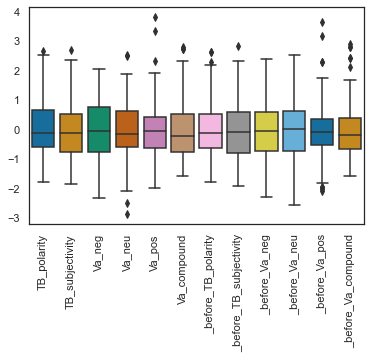

In [86]:
# Standard Scaler
columns = df_sent.columns
scaler_ss = StandardScaler()
df_ss = pd.DataFrame(scaler_ss.fit_transform(df_sent))
df_ss.columns = columns


# boxpltos after standard scaler
boxp = sns.boxplot(data=df_ss ,palette="colorblind")
boxp.set_xticklabels(boxp.get_xticklabels(),rotation=90)


#Train test split for Standard Scaler
X_train_ss, X_test_ss, y_train_ss, y_test_ss = train_test_split(df_sent, Y, test_size=0.3, random_state=42,stratify = Y, shuffle = True)

Min Max Scaled

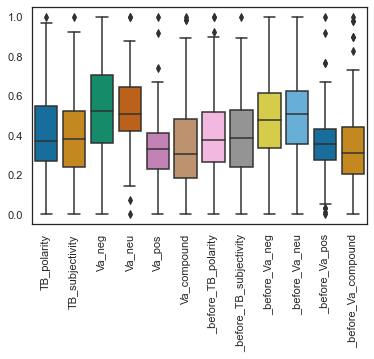

In [87]:
# Min max Scaled
columns = df_sent.columns
scaler_mm = MinMaxScaler()
df_min_max = pd.DataFrame(scaler_mm.fit_transform(df_sent))
df_min_max.columns = columns


# boxpltos after Min-Max scaled
boxp = sns.boxplot(data=df_min_max,palette="colorblind")
boxp.set_xticklabels(boxp.get_xticklabels(),rotation=90)


X_train_mm, X_test_mm, y_train_mm, y_test_mm = train_test_split(df_min_max, Y, test_size=0.3, random_state=42,stratify = Y, shuffle = True)

Robust Scaler Scaled

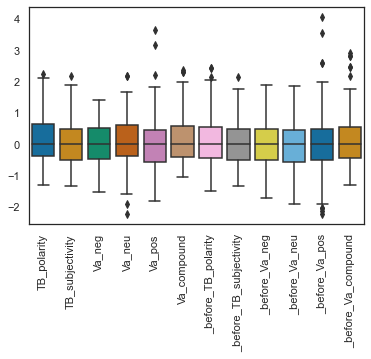

In [88]:
# Robust Scaler
columns = df_sent.columns
scaler_rs = RobustScaler()
df_rs = pd.DataFrame(scaler_rs.fit_transform(df_sent))
df_rs.columns = columns


# boxpltos after Robbust scaled
boxp = sns.boxplot(data=df_rs,palette="colorblind")
boxp.set_xticklabels(boxp.get_xticklabels(),rotation=90)


X_train_rs, X_test_rs, y_train_rs, y_test_rs = train_test_split(df_rs, Y, test_size=0.3, random_state=42,stratify = Y, shuffle = True)

Z-score approach

As with standard scaling methods, outliers remain. New approach of Z-Score
https://towardsdatascience.com/ways-to-detect-and-remove-the-outliers-404d16608dba

The Z-score is the signed number of standard deviations by which the value of an observation or data point is above the mean value of what is being observed or measured.

In [89]:
df_sent_z = df_sent
df_sent_z['y'] = Y
z = np.abs(stats.zscore(df_sent_z))
# to delete outliers
df_z_score = df_sent_z[(z < 3).all(axis=1)]
# reducing the outliers

y_z_apporach = df_z_score.y

Z-Score x Standard Scaler

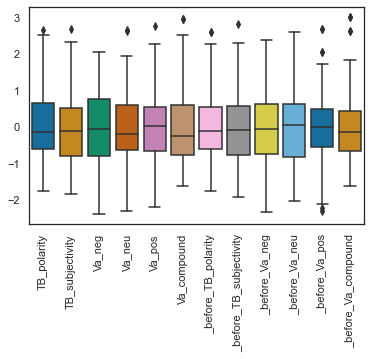

In [90]:
### Z-Standard Scaler
columns = df_sent_z.columns
scaler_zs = StandardScaler()
df_zs_num = pd.DataFrame(scaler_zs.fit_transform(df_z_score))
df_zs_num.columns = columns
df_zs_num = df_zs_num.drop(columns = ['y'])

# ZS_boxpltos
boxp_zs = sns.boxplot(data=df_zs_num,palette="colorblind")
boxp_zs.set_xticklabels(boxp_zs.get_xticklabels(),rotation=90)

### Usally take z = 3 as 3 std should cover around 99% of the data should be covered. When looked at the boxplots, there are however still outliers. Hence, approach could either adjust z further, or try predicition without customer info 2

# train test for Z score Standard
X_train_zss, X_test_zss, y_train_zss, y_test_zss = train_test_split(df_zs_num, y_z_apporach, test_size=0.3, random_state=42, shuffle = True,stratify = y_z_apporach)

Z-Score x MinMax Scaler

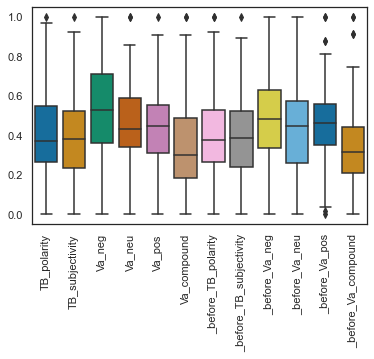

In [91]:
### Z-MinMax Scaler
scaler_zmms = MinMaxScaler()
df_zmms_num = pd.DataFrame(scaler_zmms.fit_transform(df_z_score))
df_zmms_num.columns = columns
df_zmms_num = df_zmms_num.drop(columns = ['y'])

# ZM_boxpltos
boxp_zmms = sns.boxplot(data=df_zmms_num,palette="colorblind")
boxp_zmms.set_xticklabels(boxp_zmms.get_xticklabels(),rotation=90)

### Usally take z = 3 as 3 std should cover around 99% of the data should be covered. When looked at the boxplots, there are however still outliers. Hence, approach could either adjust z further, or try predicition without customer info 2

# train test for Z score MinMax
X_train_zmms, X_test_zmms, y_train_zmms, y_test_zmms = train_test_split(df_zmms_num, y_z_apporach, test_size=0.3, random_state=42, shuffle = True,stratify = y_z_apporach)

Z-Score x Robust

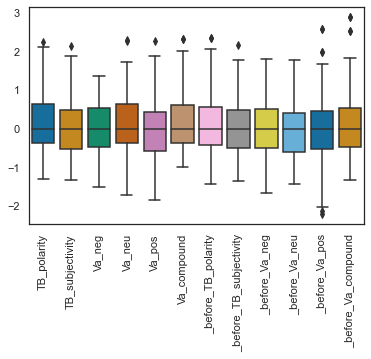

In [92]:
### Z-Robust Scaler
scaler_zrs = RobustScaler()
df_zrs_num = pd.DataFrame(scaler_zrs.fit_transform(df_z_score))
df_zrs_num.columns = columns
df_zrs_num = df_zrs_num.drop(columns = ['y'])

# ZM_boxpltos
boxp_zrs = sns.boxplot(data=df_zrs_num,palette="colorblind")
boxp_zrs.set_xticklabels(boxp_zrs.get_xticklabels(),rotation=90)

### Usally take z = 3 as 3 std should cover around 99% of the data should be covered. When looked at the boxplots, there are however still outliers. Hence, approach could either adjust z further, or try predicition without customer info 2

# train test for Z score MinMax
X_train_zrs, X_test_zrs, y_train_zrs, y_test_zrs = train_test_split(df_zrs_num, y_z_apporach, test_size=0.3, random_state=42, shuffle = True, stratify = y_z_apporach)

# ML - Classifiers Win / Lose

In [93]:
overview_train = pd.DataFrame(columns = ['algorithm','not_scaled', 'standard', 'minmax', 'robust','z_standard', 'z_minmax', 'z_robust' ])
overview_test = pd.DataFrame(columns = ['algorithm','not_scaled', 'standard', 'minmax', 'robust','z_standard', 'z_minmax', 'z_robust' ])

# Logistic Regression

accuarcy score not scaled:   0.5666666666666667


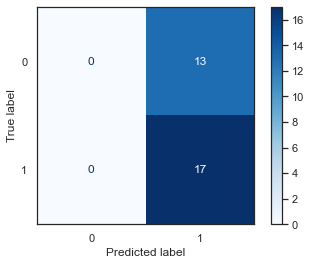

In [94]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
accuracy_lr =accuracy_score(y_pred, y_test)
print('accuarcy score not scaled:   ' + str(accuracy_score(y_pred, y_test)))
plot_confusion_matrix(logreg, X_test, y_test, cmap=plt.cm.Blues)

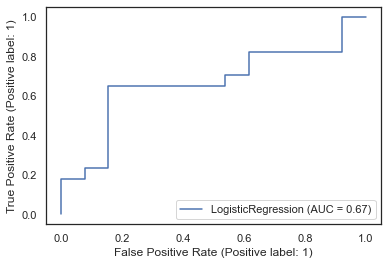

In [95]:
plot_roc_curve(logreg, X_test, y_test)


In [96]:
overview_train['not_scaled'] = [logreg.score(X_train, y_train)]
overview_test['not_scaled'] = [logreg.score(X_test, y_test)]

In [97]:
#Name 1st Row
overview_train['algorithm'] = ['logreg']
overview_test['algorithm'] = ['logreg']

#Enlarging the dataset so accuracy values later, can simply replace the NaN
overview_train = overview_train.append([0,0,0,0,0])
overview_test = overview_test.append([0,0,0,0,0])

#Rename 2nd row to XGboost_regular
overview_train['algorithm'].iloc[1] = 'xgboost'
overview_test['algorithm'].iloc[1] = 'xgboost'

#Rename 3d row to XGboost_Hyper_Tune
overview_train['algorithm'].iloc[2] = 'H_xgboost'
overview_test['algorithm'].iloc[2] = 'H-xgboost'

#Rename 4th row to XGboost_Hyper_Tune
overview_train['algorithm'].iloc[3] = 'rf'
overview_test['algorithm'].iloc[3] = 'rf'

#Rename 5th row to XGboost_Hyper_Tune
overview_train['algorithm'].iloc[4] = 'H_rf'
overview_test['algorithm'].iloc[4] = 'H_rf'

#Rename 6th row to XGboost_Hyper_Tune
overview_train['algorithm'].iloc[5] = 'gaussian'
overview_test['algorithm'].iloc[5] = 'gaussian'

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [98]:
overview_train

,0,algorithm,minmax,not_scaled,robust,standard,z_minmax,z_robust,z_standard
0,NaN,logreg,NaN,0.544118,NaN,NaN,NaN,NaN,NaN
0,0.0,xgboost,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,H_xgboost,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,rf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.0,H_rf,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.0,gaussian,NaN,NaN,NaN,NaN,NaN,NaN,NaN


MinMax Scaled

accuarcy score with MinMax scaled:   0.5666666666666667


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


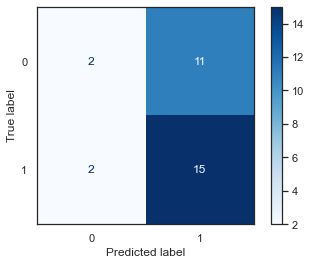

In [99]:
lr_model_mm = logreg.fit(X_train_mm, y_train_mm)
y_pred_mm = logreg.predict(X_test_mm)
accuracy_lr_mm =accuracy_score(y_pred_mm, y_test_mm)
print('accuarcy score with MinMax scaled:   ' + str(accuracy_score(y_pred_mm, y_test_mm)))
plot_confusion_matrix(lr_model_mm, X_test_mm, y_test_mm, cmap=plt.cm.Blues)

overview_train['minmax'].iloc[0] = lr_model_mm.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[0] = lr_model_mm.score(X_test_mm, y_test_mm)

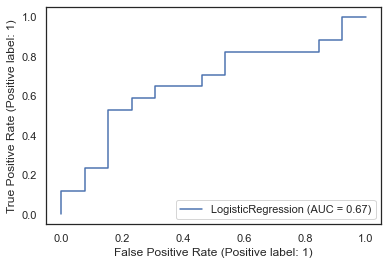

In [100]:
plot_roc_curve(lr_model_mm, X_test_mm, y_test_mm)

Standard Scaled

accuarcy score with Standard scaled:   0.5666666666666667


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


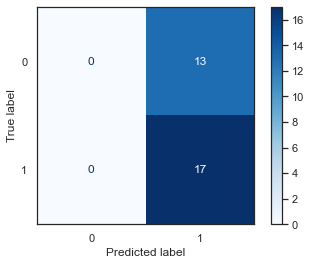

In [101]:
lr_model_ss = logreg.fit(X_train_ss, y_train_ss)
y_pred_ss = logreg.predict(X_test_ss)
accuracy_lr_ss =accuracy_score(y_pred_ss, y_test_ss)
print('accuarcy score with Standard scaled:   ' + str(accuracy_score(y_pred_ss, y_test_ss)))
plot_confusion_matrix(lr_model_ss, X_test_ss, y_test_ss, cmap=plt.cm.Blues)

overview_train['standard'].iloc[0] = lr_model_ss.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[0] = lr_model_ss.score(X_test_ss, y_test_ss)

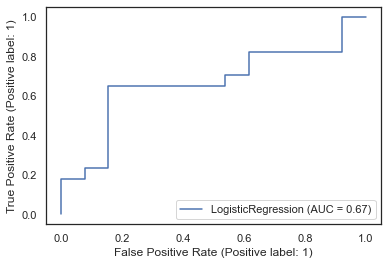

In [102]:
plot_roc_curve(lr_model_ss, X_test_ss, y_test_ss)

Robust Scaled

accuarcy score with Standard scaled:   0.6666666666666666


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


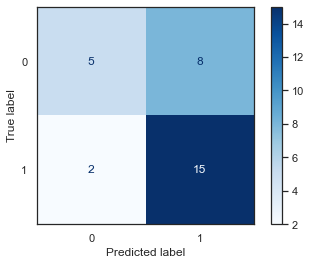

In [103]:
lr_model_rs = logreg.fit(X_train_rs, y_train_rs)
y_pred_rs = logreg.predict(X_test_rs)
accuracy_lr_rs =accuracy_score(y_pred_rs, y_test_rs)
print('accuarcy score with Standard scaled:   ' + str(accuracy_score(y_pred_rs, y_test_rs)))
plot_confusion_matrix(lr_model_rs, X_test_rs, y_test_rs, cmap=plt.cm.Blues)

overview_train['robust'].iloc[0] = lr_model_rs.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[0] = lr_model_rs.score(X_test_rs, y_test_rs)

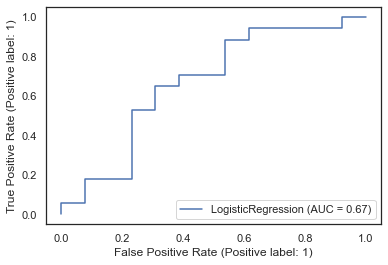

In [104]:
plot_roc_curve(lr_model_rs, X_test_rs, y_test_rs)

Z Scaled logreg

MinMax Scaled

accuarcy score with MinMax scaled:   0.5517241379310345


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


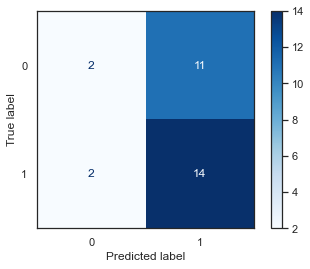

In [105]:
lr_model_zmms = logreg.fit(X_train_zmms, y_train_zmms)
y_pred_zmms = logreg.predict(X_test_zmms)
accuracy_lr_zmms =accuracy_score(y_pred_zmms, y_test_zmms)
print('accuarcy score with MinMax scaled:   ' + str(accuracy_score(y_pred_zmms, y_test_zmms)))
plot_confusion_matrix(lr_model_zmms, X_test_zmms, y_test_zmms, cmap=plt.cm.Blues)

overview_train['z_minmax'].iloc[0] = lr_model_zmms.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[0] = lr_model_zmms.score(X_test_zmms, y_test_zmms)

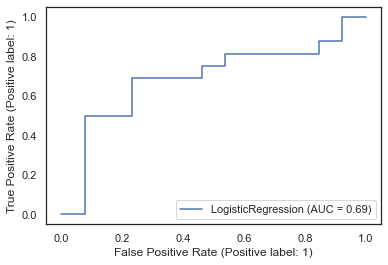

In [106]:
plot_roc_curve(lr_model_zmms, X_test_zmms, y_test_zmms)

accuarcy score with Standard scaled:   0.5862068965517241


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


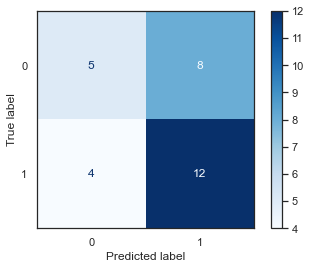

In [107]:
#Standard Scaled
lr_model_zss = logreg.fit(X_train_zss, y_train_zss)
y_pred_zss = logreg.predict(X_test_zss)
accuracy_lr_zss =accuracy_score(y_pred_zss, y_test_zss)
print('accuarcy score with Standard scaled:   ' + str(accuracy_score(y_pred_zss, y_test_zss)))
plot_confusion_matrix(lr_model_zss, X_test_zss, y_test_zss, cmap=plt.cm.Blues)

overview_train['z_standard'].iloc[0] = lr_model_zss.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[0] = lr_model_zss.score(X_test_zss, y_test_zss)

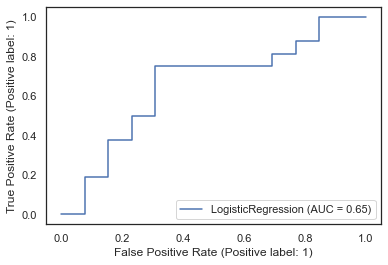

In [108]:
plot_roc_curve(lr_model_zss, X_test_zss, y_test_zss)

accuarcy score with Standard scaled:   0.5862068965517241


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


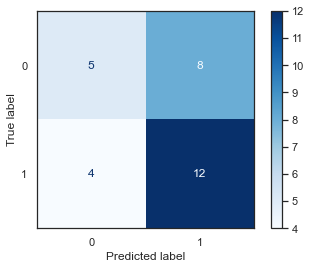

In [109]:
#Robust Scaled
lr_model_zrs = logreg.fit(X_train_zrs, y_train_zrs)
y_pred_zrs = logreg.predict(X_test_zrs)
accuracy_lr_zrs =accuracy_score(y_pred_zrs, y_test_zrs)
print('accuarcy score with Standard scaled:   ' + str(accuracy_score(y_pred_zrs, y_test_zrs)))
plot_confusion_matrix(lr_model_zrs, X_test_zrs, y_test_zrs, cmap=plt.cm.Blues)

overview_train['z_robust'].iloc[0] = lr_model_zrs.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[0] = lr_model_zrs.score(X_test_zrs, y_test_zrs)

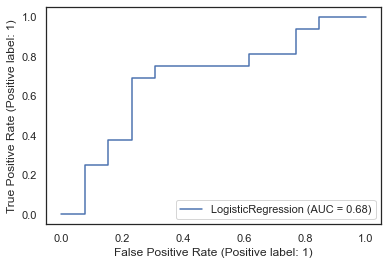

In [110]:
plot_roc_curve(lr_model_zrs, X_test_zrs, y_test_zrs)

# XG Boost

In [111]:
# no Scaling
model_xg = XGBClassifier(use_label_encoder=False)
model_xg.fit(X_train, y_train)

y_pred_xg = model_xg.predict(X_test)
accuracy_xg = accuracy_score(y_test, y_pred_xg)

[15:59:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


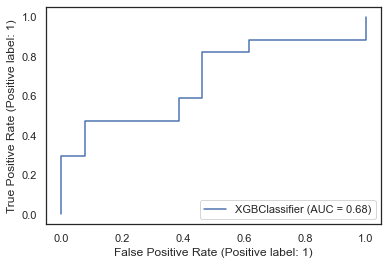

In [112]:
plot_roc_curve(model_xg, X_test, y_test)

In [113]:
overview_train['not_scaled'].iloc[1] = model_xg.score(X_train, y_train)
overview_test['not_scaled'].iloc[1] = model_xg.score(X_test, y_test)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [114]:
# MinMax
model_xg_mm = XGBClassifier(use_label_encoder=False)
model_xg_mm.fit(X_train_mm, y_train_mm)

y_pred_xg_mm = model_xg_mm.predict(X_test_mm)
accuracy_xg_mm = accuracy_score(y_test_mm, y_pred_xg_mm)

[15:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


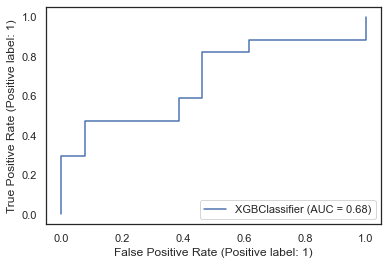

In [115]:
plot_roc_curve(model_xg_mm, X_test_mm, y_test_mm)

In [116]:
overview_train['minmax'].iloc[1] = model_xg_mm.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[1] = model_xg_mm.score(X_test_mm, y_test_mm)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [117]:
# Standard Scaled
model_xg_ss = XGBClassifier(use_label_encoder=False)
model_xg_ss.fit(X_train_ss, y_train_ss)

y_pred_xg_ss = model_xg_ss.predict(X_test_ss)
accuracy_xg_ss = accuracy_score(y_test_ss, y_pred_xg_ss)

overview_train['standard'].iloc[1] = model_xg_ss.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[1] = model_xg_ss.score(X_test_ss, y_test_ss)

[15:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


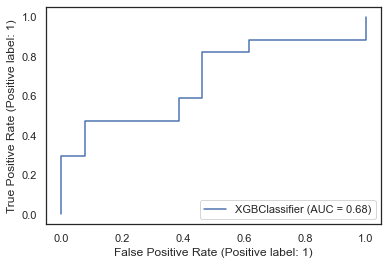

In [118]:
plot_roc_curve(model_xg_ss, X_test_ss, y_test_ss)

In [119]:
# robust Scaled
model_xg_rs = XGBClassifier(use_label_encoder=False)
model_xg_rs.fit(X_train_rs, y_train_rs)

y_pred_xg_rs = model_xg_rs.predict(X_test_rs)
accuracy_xg_rs = accuracy_score(y_test_rs, y_pred_xg_rs)

overview_train['robust'].iloc[1] = model_xg_rs.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[1] = model_xg_rs.score(X_test_rs, y_test_rs)

[15:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


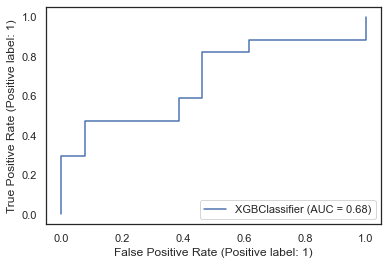

In [120]:
plot_roc_curve(model_xg_rs, X_test_rs, y_test_rs)

XGboost - z value Outlier reduction

In [121]:
# Z_MinMax
model_xg_zmms = XGBClassifier(use_label_encoder=False)
model_xg_zmms.fit(X_train_zmms, y_train_zmms)

y_pred_xg_zmms = model_xg_zmms.predict(X_test_zmms)
accuracy_xg_zmms = accuracy_score(y_test_zmms, y_pred_xg_zmms)


overview_train['z_minmax'].iloc[1] = model_xg_zmms.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[1] = model_xg_zmms.score(X_test_zmms, y_test_zmms)

[15:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [122]:
# z_Standard Scaled
model_xg_zss = XGBClassifier(use_label_encoder=False)
model_xg_zss.fit(X_train_zss, y_train_zss)

y_pred_xg_zss = model_xg_zss.predict(X_test_zss)
accuracy_xg_zss = accuracy_score(y_test_zss, y_pred_xg_zss)

overview_train['z_standard'].iloc[1] = model_xg_zss.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[1] = model_xg_zss.score(X_test_zss, y_test_zss)

[15:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [123]:
# robust Scaled
model_xg_zrs = XGBClassifier(use_label_encoder=False)
model_xg_zrs.fit(X_train_zrs, y_train_zrs)

y_pred_xg_zrs = model_xg_zrs.predict(X_test_zrs)
accuracy_xg_zrs = accuracy_score(y_test_zrs, y_pred_xg_zrs)

overview_train['z_robust'].iloc[1] = model_xg_zrs.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[1] = model_xg_zrs.score(X_test_zrs, y_test_zrs)

[15:59:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


XG-Boost including Hyperparameter tuning
accorind to: https://www.kaggle.com/prashant111/xgboost-k-fold-cv-feature-importance

In [124]:
# xgb with regular
xgb_not_scaled = XGBClassifier()

parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'objective':['binary:logistic'],
              'learning_rate': [0.01, 0.15, .02, .03],
              'max_depth': [2,3,4,5],
              'min_child_weight': [1, 1.25, 1.5,2],

              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [25,50, 100, 150, 200,300]}

xgb_grid = GridSearchCV(xgb_not_scaled,
                        parameters,
                        cv = 4,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(X_train,
         y_train)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[16:00:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.6323529411764707
{'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'nthread': 4, 'objective': 'binary:logistic', 'subsample': 0.7}


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


In [125]:
overview_train['not_scaled'].iloc[2] = xgb_grid.score(X_train, y_train)
overview_test['not_scaled'].iloc[2] = xgb_grid.score(X_test, y_test)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [126]:
# xgb with Minmax
xgb_grid.fit(X_train_mm,y_train_mm)

overview_train['minmax'].iloc[2] = xgb_grid.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[2] = xgb_grid.score(X_test_mm, y_test_mm)

# xgb with standard
xgb_grid.fit(X_train_ss,y_train_ss)

overview_train['standard'].iloc[2] = xgb_grid.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[2] = xgb_grid.score(X_test_ss, y_test_ss)

# xgb with robust
xgb_grid.fit(X_train_rs,y_train_rs)

overview_train['robust'].iloc[2] = xgb_grid.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[2] = xgb_grid.score(X_test_rs, y_test_rs)

Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[16:01:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[16:01:50] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[16:02:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bina

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A valu

XgBoost Hyper with outlier reduction

In [127]:
# z_xgb with Minmax
xgb_grid.fit(X_train_zmms,y_train_zmms)

overview_train['z_minmax'].iloc[2] = xgb_grid.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[2] = xgb_grid.score(X_test_zmms, y_test_zmms)

# z_xgb with standard
xgb_grid.fit(X_train_zss,y_train_zss)

overview_train['z_standard'].iloc[2] = xgb_grid.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[2] = xgb_grid.score(X_test_zss, y_test_zss)

# z_xgb with robust
xgb_grid.fit(X_train_zrs,y_train_zrs)

overview_train['z_robust'].iloc[2] = xgb_grid.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[2] = xgb_grid.score(X_test_zrs, y_test_zrs)



Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[16:03:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[16:03:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 4 folds for each of 384 candidates, totalling 1536 fits
[16:04:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bina

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A valu

# Random Forrest

accuarcy score not scaled:   0.6333333333333333


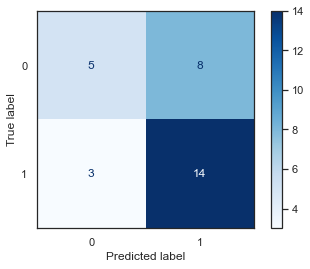

In [128]:
model_rf = RandomForestClassifier(max_depth=2, random_state=0)
model_rf.fit(X_train, y_train)
model_rf.score(X_test, y_test)

y_pred = model_rf.predict(X_test)
accuracy_rf =accuracy_score(y_pred, y_test)
print('accuarcy score not scaled:   ' + str(accuracy_score(y_pred, y_test)))
plot_confusion_matrix(model_rf, X_test, y_test, cmap=plt.cm.Blues)

In [129]:
overview_train['not_scaled'].iloc[3] = model_rf.score(X_train, y_train)
overview_test['not_scaled'].iloc[3] = model_rf.score(X_test, y_test)


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [130]:
# rf with Minmax
model_rf.fit(X_train_mm,y_train_mm)

overview_train['minmax'].iloc[3] = model_rf.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[3] = model_rf.score(X_test_mm, y_test_mm)

# rf with standard
model_rf.fit(X_train_ss,y_train_ss)

overview_train['standard'].iloc[3] = model_rf.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[3] = model_rf.score(X_test_ss, y_test_ss)

# rf with robust
model_rf.fit(X_train_rs,y_train_rs)

overview_train['robust'].iloc[3] = model_rf.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[3] = model_rf.score(X_test_rs, y_test_rs)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [131]:
# z_rf with Minmax
model_rf.fit(X_train_zmms,y_train_zmms)

overview_train['z_minmax'].iloc[3] = model_rf.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[3] = model_rf.score(X_test_zmms, y_test_zmms)

# z_rf with standard
model_rf.fit(X_train_zss,y_train_zss)

overview_train['z_standard'].iloc[3] = model_rf.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[3] = model_rf.score(X_test_zss, y_test_zss)

# z_rf with robust
model_rf.fit(X_train_zrs,y_train_zrs)

overview_train['z_robust'].iloc[3] = model_rf.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[3] = model_rf.score(X_test_zrs, y_test_zrs)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

# Random Forest Hyperparameter Tuning

In [132]:
# Instanceiate RF
rf = RandomForestClassifier(random_state = 42)

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2,3, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2,3, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
rf_param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random_h = RandomizedSearchCV(estimator = rf, param_distributions = rf_param, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)

In [133]:
# rf hyper not scaled
model_rf.fit(X_train, y_train)

overview_train['not_scaled'].iloc[4] = model_rf.score(X_train, y_train)
overview_test['not_scaled'].iloc[4] = model_rf.score(X_test, y_test)

# rf hyper with Minmax
rf_random_h.fit(X_train_mm,y_train_mm)

overview_train['minmax'].iloc[4] = rf_random_h.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[4] = rf_random_h.score(X_test_mm, y_test_mm)

# rf hyper with standard
rf_random_h.fit(X_train_ss,y_train_ss)

overview_train['standard'].iloc[4] = rf_random_h.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[4] = rf_random_h.score(X_test_ss, y_test_ss)

# rf hyper with robust
rf_random_h.fit(X_train_rs,y_train_rs)

overview_train['robust'].iloc[4] = rf_random_h.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[4] = rf_random_h.score(X_test_rs, y_test_rs)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [134]:
# z_rf hyper with Minmax
rf_random_h.fit(X_train_zmms,y_train_zmms)

overview_train['z_minmax'].iloc[4] = rf_random_h.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[4] = rf_random_h.score(X_test_zmms, y_test_zmms)

# z_rf hyper with standard
rf_random_h.fit(X_train_zss,y_train_zss)

overview_train['z_standard'].iloc[4] = rf_random_h.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[4] = rf_random_h.score(X_test_zss, y_test_zss)

# z_rf hyper with robust
rf_random_h.fit(X_train_zrs,y_train_zrs)

overview_train['z_robust'].iloc[4] = rf_random_h.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[4] = rf_random_h.score(X_test_zrs, y_test_zrs)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits
Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

# Gaussian Classifier

In [135]:
kernel_gc = 1.0 * RBF(1.0)
model_gc = GaussianProcessClassifier(kernel=kernel_gc,random_state=0)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata

accuarcy score not scaled:   0.5666666666666667


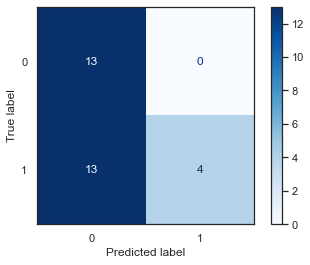

In [136]:
# no Scaling
model_gc.fit(X_train, y_train)

y_pred = model_gc.predict(X_test)
accuracy_gc =accuracy_score(y_pred, y_test)
print('accuarcy score not scaled:   ' + str(accuracy_score(y_pred, y_test)))
plot_confusion_matrix(model_gc, X_test, y_test, cmap=plt.cm.Blues)

overview_train['not_scaled'].iloc[5] = model_gc.score(X_train, y_train)
overview_test['not_scaled'].iloc[5] = model_gc.score(X_test, y_test)

In [137]:
# gc with Minmax
model_gc.fit(X_train_mm,y_train_mm)

overview_train['minmax'].iloc[5] = model_gc.score(X_train_mm, y_train_mm)
overview_test['minmax'].iloc[5] = model_gc.score(X_test_mm, y_test_mm)

# gc with standard
model_gc.fit(X_train_ss,y_train_ss)

overview_train['standard'].iloc[5] = model_gc.score(X_train_ss, y_train_ss)
overview_test['standard'].iloc[5] = model_gc.score(X_test_ss, y_test_ss)

# gc with robust
model_gc.fit(X_train_rs,y_train_rs)

overview_train['robust'].iloc[5] = model_gc.score(X_train_rs, y_train_rs)
overview_test['robust'].iloc[5] = model_gc.score(X_test_rs, y_test_rs)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\sklearn\gaussian_process\kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified low

In [138]:
# z_gc with Minmax
model_gc.fit(X_train_zmms,y_train_zmms)

overview_train['z_minmax'].iloc[5] = model_gc.score(X_train_zmms, y_train_zmms)
overview_test['z_minmax'].iloc[5] = model_gc.score(X_test_zmms, y_test_zmms)

# z_gc with standard
model_gc.fit(X_train_zss,y_train_zss)

overview_train['z_standard'].iloc[5] = model_gc.score(X_train_zss, y_train_zss)
overview_test['z_standard'].iloc[5] = model_gc.score(X_test_zss, y_test_zss)

# z_gc with robust
model_gc.fit(X_train_zrs,y_train_zrs)

overview_train['z_robust'].iloc[5] = model_gc.score(X_train_zrs, y_train_zrs)
overview_test['z_robust'].iloc[5] = model_gc.score(X_test_zrs, y_test_zrs)

c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
c:\users\marc\documents\github\02_python\07_ma thesis\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: 

In [139]:
overview_train

,0,algorithm,minmax,not_scaled,robust,standard,z_minmax,z_robust,z_standard
0,NaN,logreg,0.5,0.544118,0.602941,0.544118,0.507463,0.597015,0.61194
0,0.0,xgboost,1.0,1.000000,1.0,1.0,1.0,1.0,1.0
1,0.0,H_xgboost,0.897059,0.897059,0.897059,0.897059,0.865672,0.865672,0.865672
2,0.0,rf,0.882353,0.882353,0.882353,0.882353,0.895522,0.895522,0.895522
3,0.0,H_rf,1.0,0.882353,1.0,1.0,0.985075,0.985075,0.985075
4,0.0,gaussian,1.0,1.000000,1.0,1.0,1.0,1.0,1.0


In [140]:
overview_test

,0,algorithm,minmax,not_scaled,robust,standard,z_minmax,z_robust,z_standard
0,NaN,logreg,0.566667,0.566667,0.666667,0.566667,0.551724,0.586207,0.586207
0,0.0,xgboost,0.666667,0.666667,0.666667,0.666667,0.655172,0.655172,0.655172
1,0.0,H-xgboost,0.7,0.700000,0.7,0.7,0.62069,0.62069,0.62069
2,0.0,rf,0.633333,0.633333,0.633333,0.633333,0.758621,0.758621,0.758621
3,0.0,H_rf,0.6,0.633333,0.6,0.6,0.655172,0.655172,0.655172
4,0.0,gaussian,0.666667,0.566667,0.7,0.566667,0.655172,0.655172,0.655172


# Feature Selection

with XGboost

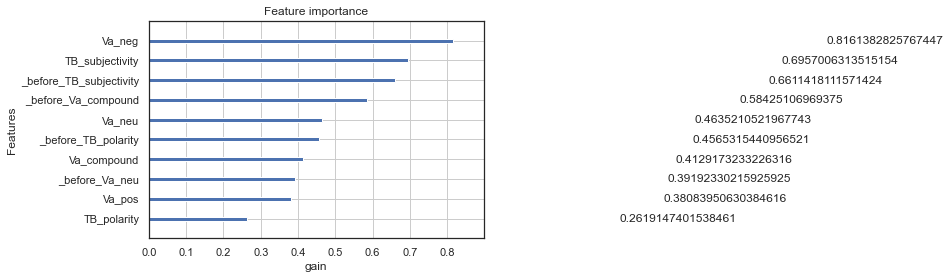

<Figure size 2592x1440 with 0 Axes>

In [141]:
xgb.plot_importance(model_xg, importance_type = 'gain', xlabel = 'gain',max_num_features=10)
plt.figure(figsize = (36, 20))
plt.show()

# Showing information Gain

In [142]:
xgb_importances = pd.Series(model_xg.feature_importances_)
columns = pd.Series(X_train.columns)

features_gain = pd.concat([columns, xgb_importances], axis = 1).rename(columns = {0: 'features', 1 : 'gini'})

In [143]:
# Filter Columns with gain > 0.1
features_gain_filtered = features_gain[features_gain.gini > 0.01].sort_values(by = 'gini', ascending = False)
features_gain_filtered

# Shwoing Gini Index

,features,gini
2,Va_neg,0.147558
1,TB_subjectivity,0.125783
7,_before_TB_subjectivity,0.119534
11,_before_Va_compound,0.105633
3,Va_neu,0.083805
6,_before_TB_polarity,0.082541
5,Va_compound,0.074655
9,_before_Va_neu,0.070860
4,Va_pos,0.068856
0,TB_polarity,0.047354


In [144]:
features_gain_filtered.head(15).features.tolist()

['Va_neg',
 'TB_subjectivity',
 '_before_TB_subjectivity',
 '_before_Va_compound',
 'Va_neu',
 '_before_TB_polarity',
 'Va_compound',
 '_before_Va_neu',
 'Va_pos',
 'TB_polarity',
 '_before_Va_pos',
 '_before_Va_neg']